In [14]:
# -*- coding: utf-8 -*-
import numpy
import pandas
import matplotlib.pyplot as plt
import datetime

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

class Prediction :

    def __init__(self):
        self.length_of_sequences = 50
        self.in_out_neurons = 1
        self.hidden_neurons = 300

    def load_data(self, data, n_prev=0):
        X, Y = [], []
        for i in range(len(data) - n_prev):
            #学習データとラベルを作成
            X.append(data.iloc[i:(i+n_prev)].as_matrix())
            Y.append(data.iloc[i+n_prev].as_matrix())
        retX = numpy.array(X)
        retY = numpy.array(Y)
        return retX, retY


    def create_model(self) :
        model = Sequential()
        #LSTM一層作成
        model.add(LSTM(self.hidden_neurons, \
                  batch_input_shape=(None, self.length_of_sequences, self.in_out_neurons), \
                  return_sequences=False ))
        #全結合層
        model.add(Dense(self.in_out_neurons))
        #活性化関数
        model.add(Activation("linear"))
        #重み更新
        model.compile(loss="mape", optimizer="adam")
        return model


    def train(self, X_train, y_train) :
        model = self.create_model()
        # 学習
        model.fit(X_train, y_train, batch_size=10, nb_epoch=30)
        return model
    
    def set_x_test(self,y_train):
        x_test = y_train[-self.length_of_sequences:]
        np_x_test = numpy.array([x_test])
        return np_x_test
        
if __name__ == "__main__":

    prediction = Prediction()

  # データ準備
    data = None
    #２００７年から2017年までのデータを仕様
    for year in range(2014, 2018):
        #データread
        data_ = pandas.read_csv('csv_stock/stocks_5406-T_1d_' + str(year) +  '.csv',encoding='shift-jis')
        #データをひとまとまりにする
        data = data_ if (data is None) else pandas.concat([data, data_])
    #カラム名変更
    data.columns = ['date', 'open', 'high', 'low', 'close','Price','Buying and selling price']
    data['date'] = pandas.to_datetime(data['date'], format='%Y-%m-%d')
    #2016年9月27以前の株価がおかしいので補正
    data.loc[(data["date"].dt.date <= datetime.date(2016, 9, 27)), 'close'] *= 10
    # 終値のデータを標準化
    data['close'] = preprocessing.scale(data['close'])
    #日でソーティングする
    data = data.sort_values(by='date')
    #インデックスをリセットする
    data = data.reset_index(drop=True)
    #日と終値のみのデータにする。
    data = data.loc[:, ['date', 'close']]


      # 2割をテストデータへ
    split_pos = int(len(data) * 0.8)
    print("data:",data['close'].shape)
    print("split_pos:",split_pos)
    
    x_train, y_train = prediction.load_data(data[['close']].iloc[0:split_pos], prediction.length_of_sequences)
    x_test_all,  y_test_all  = prediction.load_data(data[['close']].iloc[split_pos:], prediction.length_of_sequences)

    model = prediction.train(x_train, y_train)
    
    

data: (945,)
split_pos: 756


/Users/kenji_tachibana/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/30
706/706 [==============================] - 14s - loss: 40.7412    
Epoch 2/30
706/706 [==============================] - 12s - loss: 31.8442    
Epoch 3/30
706/706 [==============================] - 13s - loss: 26.6225    
Epoch 4/30
706/706 [==============================] - 13s - loss: 23.4287    
Epoch 5/30
706/706 [==============================] - 13s - loss: 20.5706    
Epoch 6/30
706/706 [==============================] - 13s - loss: 20.1466    
Epoch 7/30
706/706 [==============================] - 13s - loss: 20.1100    
Epoch 8/30
706/706 [==============================] - 13s - loss: 20.5411    
Epoch 9/30
706/706 [==============================] - 13s - loss: 19.7970    
Epoch 10/30
706/706 [==============================] - 13s - loss: 19.3883    
Epoch 11/30
706/706 [==============================] - 12s - loss: 18.3078    
Epoch 12/30
706/706 [==============================] - 12s - loss: 19.7808    
Epoch 13/30
706/706 [==============================] - 12s - 

In [15]:
predicted  = []
x_test =x_test_all[0].reshape([1,-1,1])

In [40]:
  #続けて予測し時系列データを作る
for i in range(50):
    pred = model.predict(x_test,verbose=0)
    predicted.append(pred[0])
    x_test  = numpy.append(x_test[0][1:],pred).reshape([1,-1,1])

In [17]:
for i in range(50):
    pred = model.predict(x_test)
    x_test = numpy.concatenate(
            (x_test.reshape(50, 1)[1:], pred),
            axis=0).reshape(1, 50, 1)
    
    predicted.append(pred.reshape(-1))

In [7]:
predicted = [None for i in range(30)]



for i in range(50-30):
    pred = model.predict(x_test)
    x_test = numpy.concatenate(
            (x_test.reshape(30, 1)[1:], pred),
            axis=0).reshape(1, 30, 1)
    
    predicted.append(pred.reshape(-1))

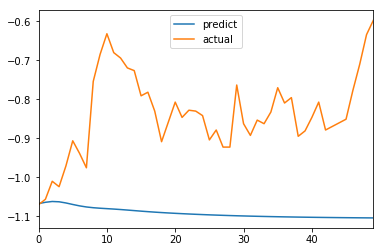

In [18]:
result = pandas.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test_all[:50]
result.plot()
plt.show()

In [21]:
result = pandas.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test[:50]
result.plot()
plt.show()

NameError: name 'y_test' is not defined

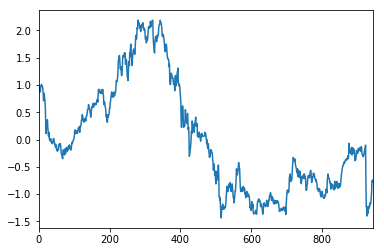

In [177]:
data["close"].plot()
plt.show()